# Simple CNN Model (Baseline)

Baseline model without accounting for class imbalance

## Imports

Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import pickle, os
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import set_random_seed
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

from src.model_api import getSimpleModel
from src.prediction import array_filter, array_to_string
from src.custom_metric import as_keras_metric

Using TensorFlow backend.


Import data

In [3]:
with open('data/derived/data_train.pickle', 'rb') as file:
    data_train = pickle.load(file)
with open('data/derived/labels_train.pickle', 'rb') as file:
    labels_train = pickle.load(file)
print('Shape of data_train:', data_train.shape)
print('Length of labels_train:', len(labels_train))

Shape of data_train: (25361, 100, 100, 3)
Length of labels_train: 25361


In [4]:
with open('data/derived/data_test.pickle', 'rb') as file:
    data_test = pickle.load(file)
with open('data/derived/test_file_names.pickle', 'rb') as file:
    filenames_test = pickle.load(file)
print('Shape of data_test:', data_test.shape)
print('Length of filename_test:', len(filenames_test))

Shape of data_test: (7960, 100, 100, 3)
Length of filename_test: 7960


Convert labels to integers for model training

In [5]:
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
print('Original labels: {}'.format(labels_train[:5]))
print('Encoded labels: {}'.format(labels_train_encoded[:5]))
print('Label encoder classes: {}'.format(label_encoder.classes_[:5]))

Original labels: ['new_whale', 'new_whale', 'w_75d0e61', 'w_396c12b', 'w_d8de44c']
Encoded labels: [   0    0 2308 1134 4209]
Label encoder classes: ['new_whale' 'w_0003639' 'w_0003c59' 'w_0027efa' 'w_00289b1']


Compute sample size and number of classes

In [6]:
sample_size = len(labels_train_encoded)
num_classes = len(set(labels_train_encoded))
print('Sample size:', sample_size)
print('Number of clases:', num_classes)

Sample size: 25361
Number of clases: 5005


## Train Single CNN Model

Simple CNN model (Random Seed = 2019, assuming class imbalance)

In [7]:
X_train = (data_train / 255).astype(np.float32)
y_train = to_categorical(labels_train_encoded, num_classes=num_classes)
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

Shape of X_train: (25361, 100, 100, 3)
Shape of y_train: (25361, 5005)


In [8]:
filepath = 'models/weights-baseline-{epoch:03d}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', save_best_only=False, save_weights_only=True,
                             mode='min')

# Create precision and recall metrics
#precision = as_keras_metric(tf.metrics.precision)
#recall = as_keras_metric(tf.metrics.recall)
#metric_list = ['accuracy', precision, recall]

model = getSimpleModel(num_classes=num_classes, resize_width=100, metric_list=None)

In [10]:
np.random.seed(2019)
set_random_seed(2019)
#model.load_weights('models/weights-baseline-080.hdf5')
hist = model.fit(X_train, y_train, epochs=100, shuffle=True, callbacks=[checkpoint], initial_epoch=0, verbose=0)

Evaluate models

Text(0, 0.5, 'Training Loss')

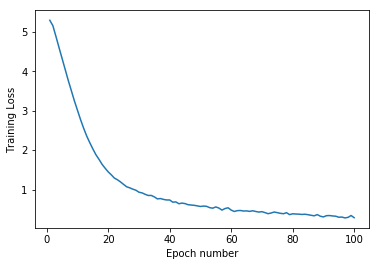

In [11]:
epoch_no_total = 100
plt.plot(list(range(1, epoch_no_total + 1)), hist.history['loss'])
plt.xlabel('Epoch number')
plt.ylabel('Training Loss')

Model prediction

In [13]:
data_test_norm = data_test / 255

model.load_weights('models/weights-baseline-020.hdf5')

# Save final weights if it doesn't exist
weights_path = 'models/weights-baseline-final.hdf5'
if os.path.exists(weights_path):
    print('Path {} exists'.format(weights_path))
else:
    model.save_weights(weights_path)

preds = model.predict(data_test_norm)

Obtain labels with top 5 softmax values for each array row and concatenate labels

In [14]:
top5_indices = np.apply_along_axis(array_filter, arr=preds, axis=1, n_top=5, labels=label_encoder.classes_)
predictions_array = np.apply_along_axis(array_to_string, arr=top5_indices, axis=1)

Create submission DataFrame and export as CSV file

In [15]:
submission_df = pd.DataFrame({'Image': filenames_test, 'Id': predictions_array})
submission_df.to_csv('data/derived/submission_v0.csv', index=False)
print(submission_df.head())

           Image                                                 Id
0  660352b03.jpg  w_c6b4d61 w_f829227 w_fd3e556 w_af367c3 w_9544084
1  bec66f23c.jpg  w_b423e9b w_95c932d w_7d6527e w_b7e3a9f w_0e4b65e
2  fb8c2c146.jpg  new_whale w_f128a4d w_27597ff w_dee1053 w_0ef790d
3  0ff9cd790.jpg  w_09c737d w_9da1811 w_0d7b050 w_45a6d4e w_fc6f897
4  861e6c332.jpg  new_whale w_21b2790 w_77c86af w_a0534e5 w_4b4f9b7


Kaggle score: 0.185